In [1]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                   BatchNormalization, Input, GlobalAveragePooling2D, 
                                   Concatenate, ReLU, Add)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
import numpy as np
import os
import cv2
import random
import albumentations as A
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Introduce randomness
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  

# === Configuration ===
config = {
    "epochs": 50,
    "is_config_batch_size_param": True, # True means use the below batch_size parameter‌ / else let the function calculate the batch size
    "batch_size": 200,
    "initial_lr": 0.001,
    "gpu_memory_limit": 48,  # in GB
    "target_size": (480, 640),  # 2:3 ratio (width, height)
    "input_shape": (640, 480, 3), # (height, width, channels) for Keras
    "data_path": "Dataset/train_images/",
    "csv_path": "processed_data/cleaned_metadata.csv", # _short is for testing only
    "train_set_csv": "Model/training6_resnet18_rgb/training6_resnet18_rgb_train_set.csv",
    "val_set_csv": "Model/training6_resnet18_rgb/training6_resnet18_rgb_validation_set.csv",
    "history_csv": "Model/training6_resnet18_rgb/training6_resnet18_rgb_history.csv",
    "best_model": "Model/training6_resnet18_rgb/training6_resnet18_rgb_best_model.keras",
    "label_encoder_path": "Model/training6_resnet18_rgb/training6_resnet18_rgb_label_encoder.npy",
    "color_channel": "",
    "augmentation": [
            # A.RandomRotate90(),
            # A.HorizontalFlip(),
            # A.VerticalFlip(),
            # A.Transpose(),
            # A.RandomBrightnessContrast(p=0.5),
            # A.HueSaturationValue(p=0.5),
            # A.CLAHE(p=0.5),
            A.Resize(width=480, height=640),
        ]
}



2025-05-12 03:51:20.992956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-12 03:51:20.993002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-12 03:51:20.994352: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 03:51:21.001277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# === GPU Setup ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)
        tf.config.threading.set_intra_op_parallelism_threads(8)
        tf.config.threading.set_inter_op_parallelism_threads(4)
    except RuntimeError as e:
        print(e)

# === Memory Management ===
def calculate_max_batch_size(model, input_shape, gpu_mem=24, default_batch=32, is_use_config_batch_size_param=config["is_config_batch_size_param"]):
    """Improved batch size calculator with error handling"""
    if is_use_config_batch_size_param:
        return default_batch
    try:
        params = model.count_params()
        
        last_dense = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Dense):
                last_dense = layer
                if layer.name == 'features':  
                    break
        
        if last_dense is None:
            raise ValueError("No Dense layer found in model!")
        
        # Memory per sample = weights + activations (in GB)
        per_sample = (
            (params * 4) +                 
            (np.prod(input_shape) * last_dense.units * 4)  
        ) / (1024 ** 3)
        
        # Max batch size with 3GB safety margin
        max_batch = int((gpu_mem - 3) / per_sample)
        return min(256, max_batch)  
    
    except Exception as e:
        print(f"Warning: Batch size estimation failed, using default={default_batch}. Error: {e}")
        return default_batch

def cleanup_gpu_memory():
    """Force clear GPU memory"""
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    if tf.config.list_physical_devices('GPU'):
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

# === Data Pipeline ===
def load_and_preprocess_data(random_state=42, save_splits=True):
    """Load and split data with fixed random state for reproducibility"""
    df = pd.read_csv(config["csv_path"])
    
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    print(f"Label classes: {le.classes_}")
    
    with open(config['label_encoder_path'], 'wb') as f:
        np.save(f, le.classes_)
    
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'],
        random_state=random_state,
    )
    
    if save_splits:
        train_df.to_csv(config['train_set_csv'], index=False)
        val_df.to_csv(config['val_set_csv'], index=False)
    
    return train_df, val_df, le


In [3]:
# === Model Architecture ===
def residual_block(x, filters, strides=1):
    shortcut = x
    
    x = Conv2D(filters, (3,3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1,1), strides=strides)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    return ReLU()(x)

def create_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape, dtype=tf.float32)
    
    # Initial conv
    x = Conv2D(64, (7,7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, strides=2)
    x = residual_block(x, 512)
    
    # Head
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

class RiceDataGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, target_size={config['target_size']}, shuffle=False, debug=False, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.batch_size = batch_size
        self.target_size = target_size  
        self.shuffle = shuffle
        self.debug = debug
        self.indices = np.arange(len(df))
        
        self.aug = A.Compose(config["augmentation"])
        
        if shuffle:
            np.random.shuffle(self.indices)
            
        if self.debug:
            self.visualize_samples()    
            

    def visualize_samples(self):        
        try:
            row = self.df.iloc[0]
            img = self._load_image(row['image_id'], row['label'])
            augmented = self.aug(image=img)
            
            plt.figure(figsize=(12, 6))
            
            # original
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Original\nShape: {img.shape}")
            
            # augmented
            plt.subplot(1, 2, 2)
            plt.imshow(augmented['image'])
            plt.title(f"Augmented\nShape: {augmented['image'].shape}")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Visualization failed for {row['image_id']}: {str(e)}")
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def _load_image(self, image_id, label, suffix=config["color_channel"]):
        img_path = os.path.join(
            self.base_path,
            label,
            f"{os.path.splitext(image_id)[0]}{suffix}.jpg"
        )
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        return img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
        y = np.zeros((len(batch_df),), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                img = self._load_image(row['image_id'], row['label'])
                augmented = self.aug(image=img)
                X[i] = augmented['image'] / 255.0
                y[i] = row['label_encoded']
            except Exception as e:
                print(f"Error loading {row['image_id']}: {str(e)}")
                X[i] = np.zeros((self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
                y[i] = -1
                
        valid = y != -1
        return X[valid], y[valid]

# === Training ===
def train():
    cleanup_gpu_memory()
    
    try:
        train_df, val_df, le = load_and_preprocess_data(random_state=42)
        num_classes = len(le.classes_)
        print("Classes: ", num_classes)
        
        # Create the mopdel
        input_shape = config["input_shape"] 
        model = create_resnet(input_shape, num_classes)
        
        # Find optimal batch size
        cleanup_gpu_memory()
        optimized_batch_size = calculate_max_batch_size(
                                    model, 
                                    input_shape=config["input_shape"],
                                    gpu_mem=config["gpu_memory_limit"],
                                    default_batch=config["batch_size"],
                                )
        
        print(f"\n=== Training Configuration ===")
        print(f"Batch size: {optimized_batch_size}")
        print(f"Input size: {config['target_size']}")
        print(f"Classes: {num_classes}")
        print(f"GPU Memory: {config['gpu_memory_limit']}GB\n")
        print(f"Model input shape: {model.input_shape}")
        
        # Create generators for training and validation
        train_gen = RiceDataGenerator(
            df=train_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False,
            debug=True
        )
        
        val_gen = RiceDataGenerator(
            df=val_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False,
            debug=False
        )
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        sample_batch = train_gen[0]
        print(f"Generator output shape: {sample_batch[0].shape}")
        print(f"Model input shape: {model.input_shape}")
        
        # Train
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=config["epochs"],
            callbacks=[
                    tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=5,  # Stop if no improvement in 5 epochs
                    mode='max',
                    restore_best_weights=True  
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    config["best_model"],  
                    save_weights_only=False,
                    monitor='val_accuracy',
                    save_best_only=True # Save the best model
                ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy',
                    factor=0.5,  # Halve Learn Rate if no improvement
                    patience=3,
                    mode='max'
                )
            ]
        )
        
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.axhline(y=max(history.history['val_accuracy']), color='r', linestyle='--', label='Best Val Accuracy')
        plt.legend()
        
        return model, history
        
    except Exception as e:
        print(f"Training failed: {e}")
        cleanup_gpu_memory()
        raise

In [4]:
def evaluate_saved_model(model_path, use_val_set=True):
    """Deterministic evaluation with debug checks"""
    try:
        # Load model 
        with open(config['label_encoder_path'], 'rb') as f:
            classes = np.load(f, allow_pickle=True)
        le = LabelEncoder()
        le.classes_ = classes

        model = tf.keras.models.load_model(model_path, compile=False) 
            
        cleanup_gpu_memory()
        optimized_batch_size = calculate_max_batch_size(
                                    model, 
                                    input_shape=config["input_shape"],
                                    gpu_mem=config["gpu_memory_limit"],
                                    default_batch=config["batch_size"],
                                )
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')
            ]
        )

        eval_df = pd.read_csv(config["val_set_csv"]) if use_val_set else load_and_preprocess_data(save_splits=False)[1]
        print(f"Evaluating on {len(eval_df)} samples")

        eval_gen = RiceDataGenerator(
            df=eval_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,  
            target_size=config["target_size"],
            shuffle=False,  
            debug=False,
        )

        # Inspect first batch
        x_test, y_test = eval_gen[0]
        print(f"\n[DEBUG] First batch - X shape: {x_test.shape}, y shape: {y_test.shape}")
        print(f"[DEBUG] Sample label: {y_test[0]} -> {le.classes_[y_test[0]]}")

        # Standard evaluation
        results = model.evaluate(eval_gen, verbose=1, return_dict=True)
        print("\n[METRICS] Evaluation Results:", results)

        # Collect all predictions
        y_true, y_pred = [], []
        for i in range(len(eval_gen)):
            x, y = eval_gen[i]
            y_true.extend(y)
            y_pred.extend(model.predict(x, verbose=0).argmax(axis=1))  # Get class indices

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        assert len(y_true) == len(y_pred), "Label/prediction length mismatch!"

        # Print sample predictions
        print("\n[PREDICTION SAMPLES]")
        for i in range(min(5, len(y_true))):
            print(f"True: {le.classes_[y_true[i]]} ({y_true[i]}) | Pred: {le.classes_[y_pred[i]]} ({y_pred[i]})")

        # Confusion Matrix Analysis
        print("\n[CONFUSION MATRIX PARAMETERS]")
        print(f"- Classes: {le.classes_}")  # Class names from LabelEncoder
        print(f"- Total samples: {len(y_true)}")
        print(f"- Batch size: {optimized_batch_size} (affects matrix granularity)")
        print(f"- Most confused classes: Will be visible in plot")

        # Plot both normalized and raw counts
        plot_confusion_matrix(
            y_true, 
            y_pred, 
            classes=le.classes_,
            normalize=True,
            title='Normalized Confusion Matrix (%)'
        )

        plot_confusion_matrix(
            y_true,
            y_pred,
            classes=le.classes_,
            normalize=False,
            title='Confusion Matrix (Counts)'
        )

        # Additional metrics
        from sklearn.metrics import classification_report
        print("\n[CLASSIFICATION REPORT]")
        print(classification_report(y_true, y_pred, target_names=le.classes_))

        return results

    except Exception as e:
        print(f"Evaluation failed: {e}")
        raise
    
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None):
    """
    Plots the confusion matrix.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        classes: List of class names
        normalize: Whether to normalize the matrix
        title: Plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, xticklabels=classes, yticklabels=classes,
                cmap='Blues', cbar=False)
    
    plt.title(title or 'Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Label classes: ['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']
Classes:  10


2025-05-12 03:51:24.233917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46866 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:c4:00.0, compute capability: 8.6



=== Training Configuration ===
Batch size: 200
Input size: (480, 640)
Classes: 10
GPU Memory: 48GB

Model input shape: (None, 640, 480, 3)


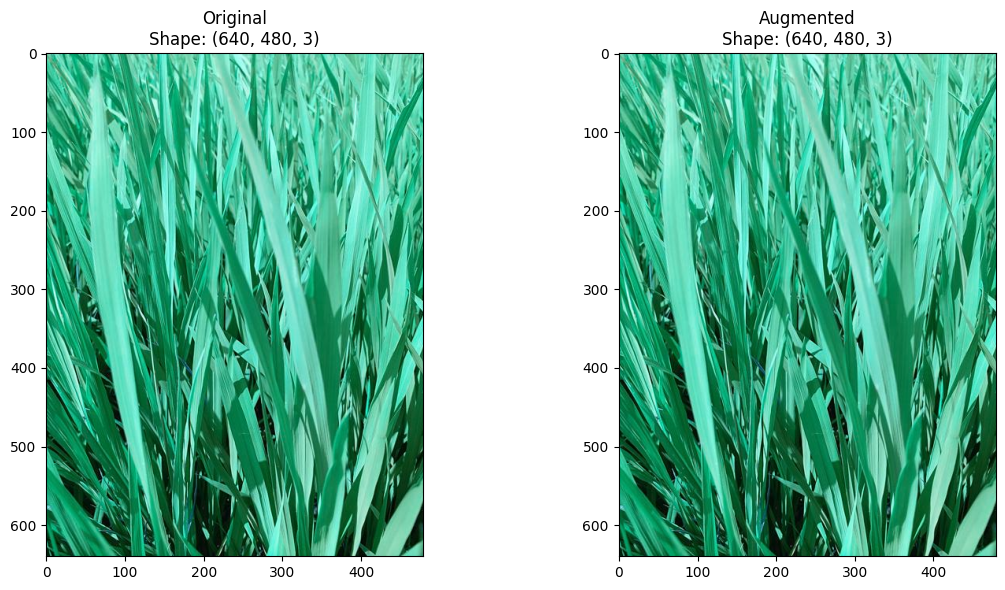

Generator output shape: (200, 640, 480, 3)
Model input shape: (None, 640, 480, 3)
Epoch 1/50


2025-05-12 03:51:34.590496: I external/local_xla/xla/service/service.cc:168] XLA service 0xa497a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-12 03:51:34.590561: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-12 03:51:34.621461: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-12 03:51:34.788280: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
W0000 00:00:1747021910.979022   29775 hlo_rematerialization.cc:2946] Can't reduce memory use below 13.49GiB (14480066033 bytes) by rematerialization; only reduced to 25.00GiB (26843037020 bytes), down from 25.00GiB (26843037020 bytes) originally
I0000 00:00:1747021911.995856   29775 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most 

41/41 [==============================] - 213s 3s/step - loss: 2.1131 - accuracy: 0.3047 - val_loss: 19.4063 - val_accuracy: 0.1881 - lr: 0.0010
Epoch 2/50
40/41 [============================>.] - ETA: 2s - loss: 1.5887 - accuracy: 0.4693

W0000 00:00:1747022201.004562   29775 hlo_rematerialization.cc:2946] Can't reduce memory use below 18.01GiB (19336283633 bytes) by rematerialization; only reduced to 20.00GiB (21479714140 bytes), down from 20.00GiB (21479714140 bytes) originally
2025-05-12 03:57:17.572364: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[160,3,641,481]{3,2,1,0}, f32[160,64,320,240]{3,2,1,0}), window={size=7x7 stride=2x2 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2025-05-12 03:57:17.718277: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.146070944s
Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[160,3,641,481]{3,2,1,0}, f32[160,64,320,240]{3,2,1,0}), window={size=7x7 

41/41 [==============================] - 169s 4s/step - loss: 1.5859 - accuracy: 0.4697 - val_loss: 3.0362 - val_accuracy: 0.1818 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 118s 3s/step - loss: 1.3627 - accuracy: 0.5368 - val_loss: 5.6152 - val_accuracy: 0.1700 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 119s 3s/step - loss: 1.1568 - accuracy: 0.6047 - val_loss: 6.2127 - val_accuracy: 0.1685 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 118s 3s/step - loss: 0.9477 - accuracy: 0.6824 - val_loss: 7.3716 - val_accuracy: 0.1779 - lr: 5.0000e-04
Epoch 6/50
41/41 [==============================] - 119s 3s/step - loss: 0.8154 - accuracy: 0.7312 - val_loss: 6.0904 - val_accuracy: 0.1788 - lr: 5.0000e-04
Evaluating on 2041 samples

[DEBUG] First batch - X shape: (200, 640, 480, 3), y shape: (200,)
[DEBUG] Sample label: 5 -> dead_heart
11/11 [==============================] - 24s 2s/step - loss: 19.4063 - acc: 0.1881 - top3_acc: 0.490

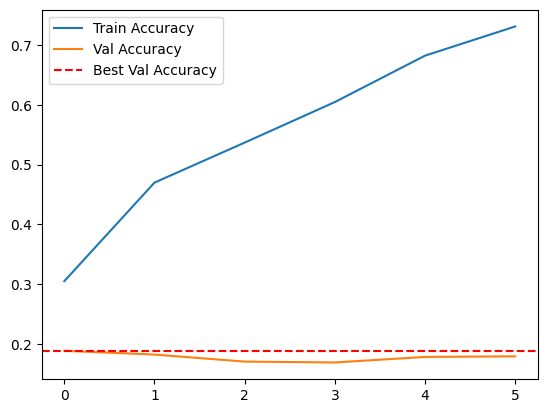

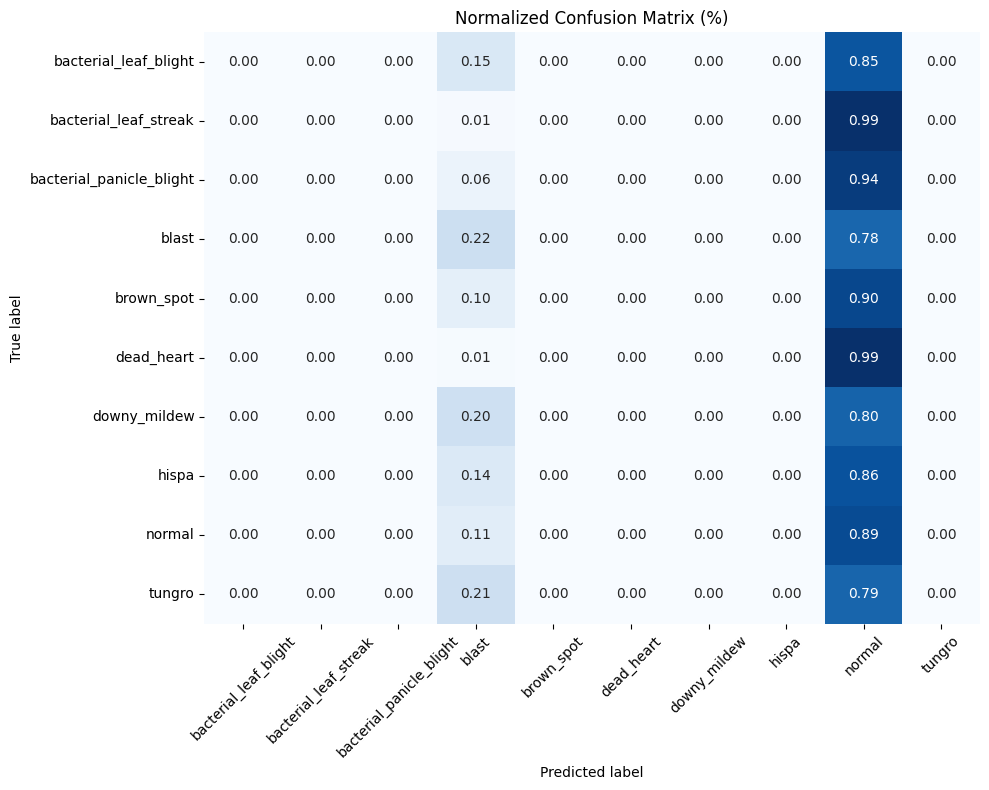

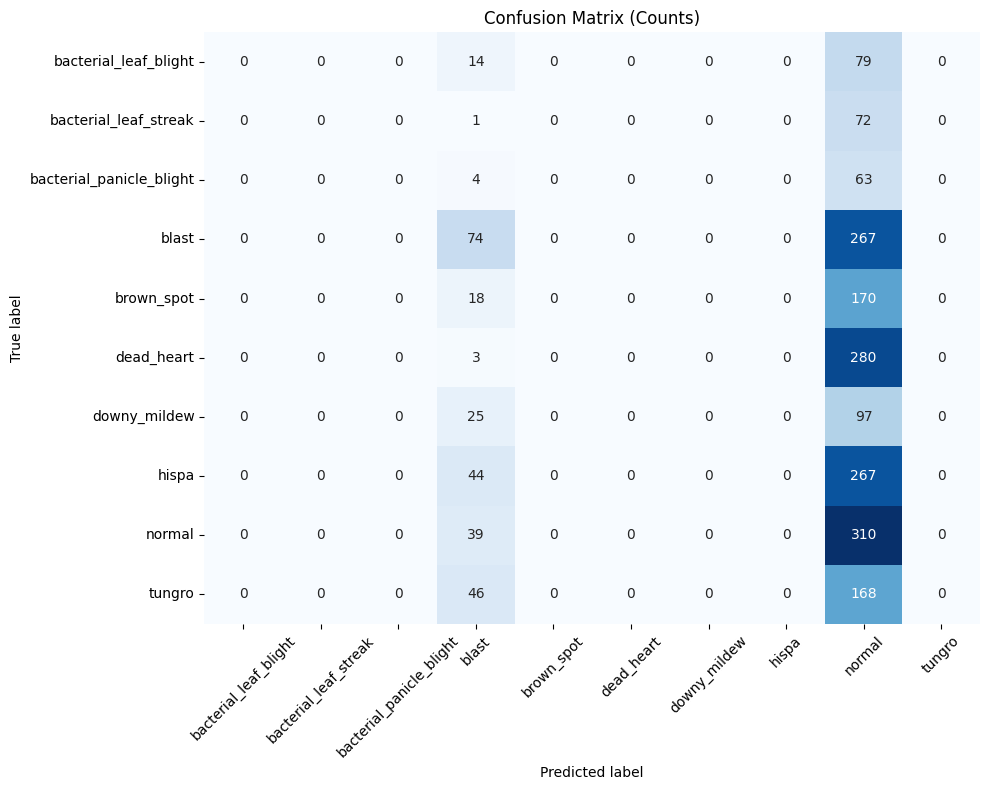


[CLASSIFICATION REPORT]
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.00      0.00      0.00        93
   bacterial_leaf_streak       0.00      0.00      0.00        73
bacterial_panicle_blight       0.00      0.00      0.00        67
                   blast       0.28      0.22      0.24       341
              brown_spot       0.00      0.00      0.00       188
              dead_heart       0.00      0.00      0.00       283
            downy_mildew       0.00      0.00      0.00       122
                   hispa       0.00      0.00      0.00       311
                  normal       0.17      0.89      0.29       349
                  tungro       0.00      0.00      0.00       214

                accuracy                           0.19      2041
               macro avg       0.05      0.11      0.05      2041
            weighted avg       0.08      0.19      0.09      2041



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'loss': 19.40630340576172,
 'acc': 0.1881430745124817,
 'top3_acc': 0.4904458522796631}

In [5]:
# === Execution Options ===
model, model_history = train()
# model.save(config["best_model"])
evaluate_saved_model(config["best_model"], use_val_set=True)